In [63]:
from __future__ import print_function, division

import torch
import torch.cuda
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import os
import time
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.ion()

In [64]:
model = models.resnet18(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False

In [65]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [66]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [67]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/hyz/prog/data/data_10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [68]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

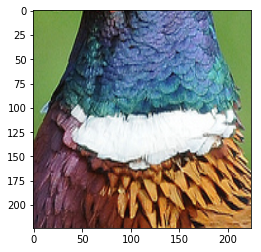


 0
 3
 2
 1
[torch.LongTensor of size 4]

In [69]:
inputs, classes = next(iter(dataloaders['train']))
imshow(inputs[0])
classes

In [72]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels).half()

                # backward + optimize only if in training phase
                if phase == 'train':
                    
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [73]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                    num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1186 Acc: 0.8308
val Loss: 2.4839 Acc: 0.0517

Epoch 1/4
----------
train Loss: 0.1530 Acc: 0.7962
val Loss: 2.5339 Acc: 0.0743

Epoch 2/4
----------
train Loss: 0.1465 Acc: 0.8000
val Loss: 2.6875 Acc: 0.0771

Epoch 3/4
----------
train Loss: 0.1328 Acc: 0.8038
val Loss: 2.4641 Acc: 0.0696

Epoch 4/4
----------
train Loss: 0.1351 Acc: 0.8308
val Loss: 2.6370 Acc: 0.0677

Training complete in 1m 2s
Best val Acc: 0.077140


In [62]:
optimizer.zero_grad()
inputs, labels = next(iter(dataloaders['train']))
inputs = Variable(inputs.cuda())
labels = Variable(labels.cuda())

outputs = model(inputs)
_, preds = torch.max(outputs.data, 1)
loss = criterion(outputs, labels).half()
loss.backward()
print(model.fc.bias.grad.data.half())


Variable containing:
-0.2370
-0.2415
-0.4923
 0.0170
 0.0076
 0.0111
 0.0161
 0.0143
 0.0183
 0.0071
 0.0052
 0.0059
 0.0047
 0.0211
 0.0051
 0.0046
 0.0129
 0.0138
 0.0088
 0.0138
 0.0128
 0.0084
 0.0174
 0.0081
 0.0046
 0.0090
 0.0029
 0.0128
 0.0084
 0.0077
 0.0037
 0.0067
 0.0137
 0.0126
 0.0040
 0.0084
 0.0102
 0.0111
 0.0129
 0.0270
 0.0112
 0.0060
 0.0119
 0.0088
 0.0060
 0.0053
 0.0070
 0.0384
 0.0100
 0.0134
 0.0053
 0.0113
 0.0047
 0.0105
 0.0134
 0.0100
 0.0103
 0.0143
 0.0092
 0.0080
 0.0080
 0.0077
 0.0058
 0.0080
 0.0106
 0.0209
 0.0195
 0.0084
 0.0068
 0.0140
 0.0086
 0.0103
 0.0077
 0.0110
 0.0046
 0.0048
 0.0077
 0.0057
 0.0143
 0.0077
 0.0120
 0.0100
 0.0189
 0.0119
 0.0094
 0.0076
 0.0043
 0.0047
 0.0045
 0.0078
 0.0117
 0.0056
 0.0167
 0.0095
 0.0091
 0.0083
 0.0061
 0.0036
 0.0073
 0.0052
[torch.cuda.FloatTensor of size 100 (GPU 0)]

Variable containing:
-0.2370
-0.2415
-0.4923
 0.0170
 0.0076
 0.0111
 0.0161
 0.0143
 0.0183
 0.0071
 0.0052
 0.0059
 0.0047
 0.0211


defaultdict(dict, {})

In [33]:
torch.cuda.


 197
  52
 214
 ⋮  
  72
  11
   0
[torch.ByteTensor of size 263688]